<a href="https://colab.research.google.com/github/davideochoa/BackEnd/blob/main/A1.2%20Caso%20Pr%C3%A1ctico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Numéricas: 14 ['Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count', 'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1'] ...
Categóricas: 5 ['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
=== Baseline_Dummy ===
              precision    recall  f1-score   support

           0     0.8396    1.0000    0.9128      1701
           1     0.0000    0.0000    0.0000       325

    accuracy                         0.8396      2026
   macro avg     0.4198    0.5000    0.4564      2026
weighted avg     0.7049    0.8396    0.7664      2026



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


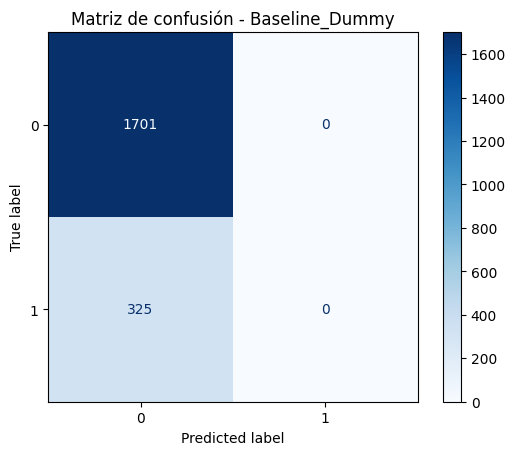

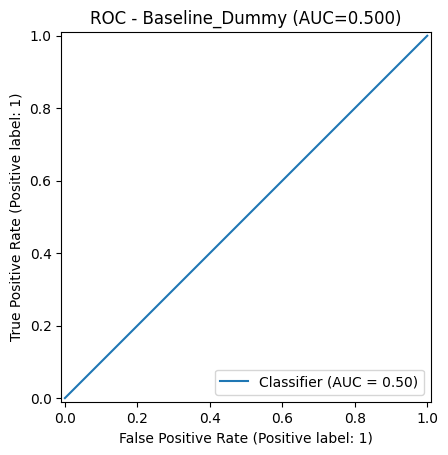

=== LogisticRegression ===
              precision    recall  f1-score   support

           0     0.9613    0.8618    0.9089      1701
           1     0.5309    0.8185    0.6441       325

    accuracy                         0.8549      2026
   macro avg     0.7461    0.8402    0.7765      2026
weighted avg     0.8923    0.8549    0.8664      2026



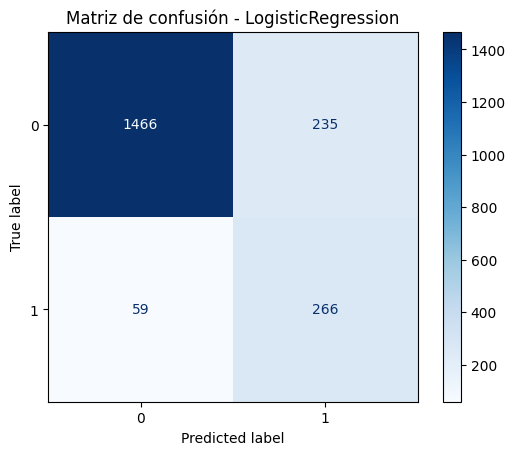

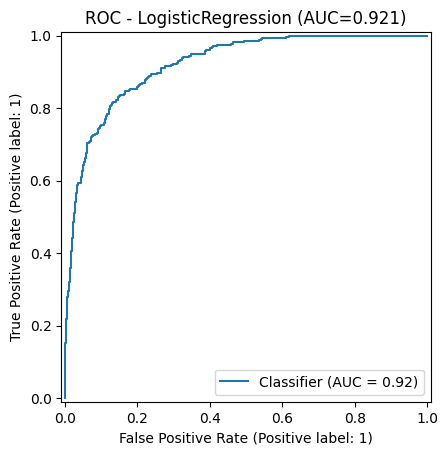

=== RandomForest ===
              precision    recall  f1-score   support

           0     0.9525    0.9894    0.9706      1701
           1     0.9305    0.7415    0.8253       325

    accuracy                         0.9497      2026
   macro avg     0.9415    0.8655    0.8980      2026
weighted avg     0.9489    0.9497    0.9473      2026



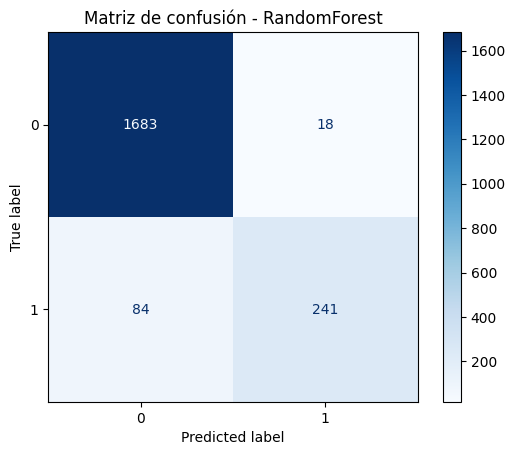

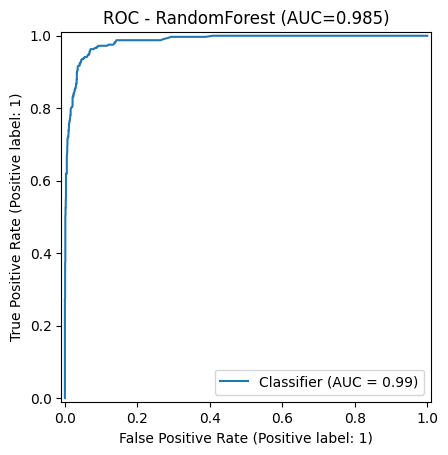

Top 20 features:
                           feature  importance
11                  Total_Trans_Ct    0.198802
10                 Total_Trans_Amt    0.194652
7              Total_Revolving_Bal    0.107036
12             Total_Ct_Chng_Q4_Q1    0.099410
13           Avg_Utilization_Ratio    0.062150
9             Total_Amt_Chng_Q4_Q1    0.060333
3         Total_Relationship_Count    0.044783
4           Months_Inactive_12_mon    0.032067
8                  Avg_Open_To_Buy    0.030475
6                     Credit_Limit    0.029889
0                     Customer_Age    0.027231
5            Contacts_Count_12_mon    0.024013
2                   Months_on_book    0.021367
1                  Dependent_count    0.010796
14                        Gender_F    0.005500
15                        Gender_M    0.004943
24          Marital_Status_Married    0.004833
25           Marital_Status_Single    0.003788
31  Income_Category_Less than $40K    0.002888
18        Education_Level_Graduate    0.002

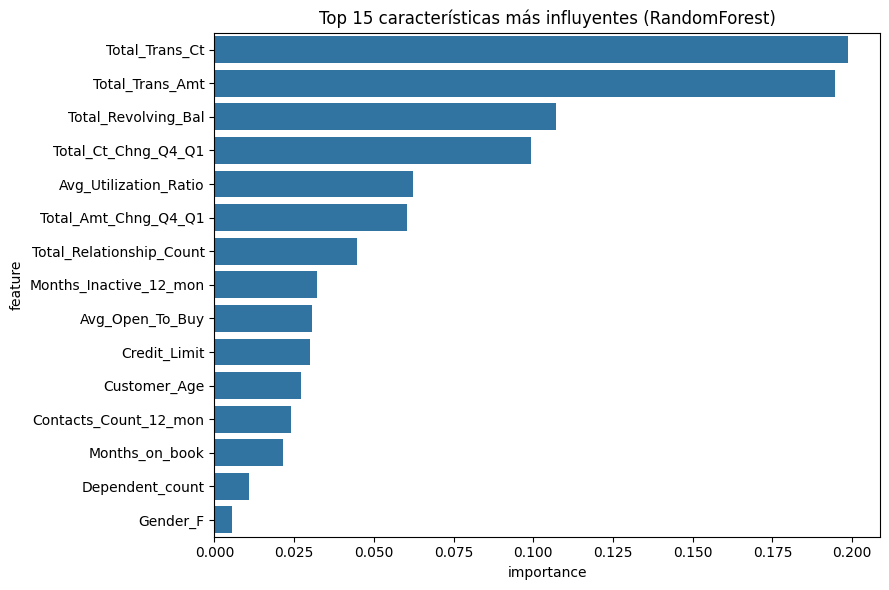

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, RocCurveDisplay

RANDOM_STATE = 42

# 1) Carga
df = pd.read_csv('sample_data/BankChurners2.csv')

# 2) Limpieza básica
# Excluir columnas no deseadas
drop_cols = [c for c in df.columns if c.startswith('Naive_Bayes_Classifier_')]
drop_cols += ['CLIENTNUM']
df = df.drop(columns=drop_cols)

# 3) Target binario
df['Attrition_Flag'] = df['Attrition_Flag'].map({'Existing Customer': 0, 'Attrited Customer': 1})

target = 'Attrition_Flag'
X = df.drop(columns=[target])
y = df[target]

# 4) Tipos de columnas
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print('Numéricas:', len(num_cols), num_cols[:10], '...')
print('Categóricas:', len(cat_cols), cat_cols)

# 5) Preprocesamiento
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, num_cols),
        ('cat', categorical_pipeline, cat_cols)
    ],
    remainder='drop'
)

# 6) Split estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# 7) Modelos
models = {
    'Baseline_Dummy': Pipeline([
        ('prep', preprocess),
        ('clf', DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE))
    ]),
    'LogisticRegression': Pipeline([
        ('prep', preprocess),
        ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=None))
    ]),
    'RandomForest': Pipeline([
        ('prep', preprocess),
        ('clf', RandomForestClassifier(
            n_estimators=400,
            max_depth=None,
            min_samples_split=2,
            random_state=RANDOM_STATE,
            class_weight='balanced',
            n_jobs=-1
        ))
    ])
}

# 8) Entrenamiento y evaluación
results = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f'=== {name} ===')
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Matriz de confusión - {name}')
    plt.show()

    # ROC-AUC (si el modelo soporta predict_proba)
    auc = None
    if hasattr(pipe.named_steps['clf'], 'predict_proba'):
        y_proba = pipe.predict_proba(X_test)[:,1]
        auc = roc_auc_score(y_test, y_proba)
        RocCurveDisplay.from_predictions(y_test, y_proba)
        plt.title(f'ROC - {name} (AUC={auc:.3f})')
        plt.show()

    results.append((name, auc))

# 9) Importancia de variables (RandomForest)
rf_pipe = models['RandomForest']
# Reentrenado por seguridad (ya entrenado arriba)
# rf_pipe.fit(X_train, y_train)

# Nombres finales tras OneHot
ohe = rf_pipe.named_steps['prep'].named_transformers_['cat'].named_steps['onehot']
cat_feature_names = ohe.get_feature_names_out(cat_cols) if len(cat_cols) > 0 else np.array([])
feature_names = np.concatenate([num_cols, cat_feature_names])

importances = rf_pipe.named_steps['clf'].feature_importances_

feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print('Top 20 features:')
print(feat_imp.head(20))

plt.figure(figsize=(9,6))
sns.barplot(data=feat_imp.head(15), x='importance', y='feature')
plt.title('Top 15 características más influyentes (RandomForest)')
plt.tight_layout()
plt.show()

# 10) Nota de despliegue (conceptual)
# from joblib import dump
# dump(rf_pipe, 'bank_churn_pipeline.joblib')